<a href="https://colab.research.google.com/github/ardadalyanci/weather-forecasting-model/blob/main/WeatherFore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import pandas as pd
from datetime import datetime, timedelta

In [ ]:
TOKEN = 'wizJhjCDVizGWrXlhAhxIGfFtPINsGzb'
STATION_ID = 'GHCND:USW00023183'
API_ENDPOINT = 'https://www.ncdc.noaa.gov/cdo-web/api/v2/data'
headers = {'token': TOKEN}
all_results = []
years = [2023, 2024]
print("Fetching data from NOAA...")
from datetime import date, timedelta
for year in years:
    print(f"Getting data for {year}...")
    start_date = f'{year}-01-01'
    if year == date.today().year:
        end_date = (date.today() - timedelta(days=1)).strftime('%Y-%m-%d')
    else:
        end_date = f'{year}-12-31'
    params = {
        'datasetid' : 'GHCND',
        'datatypeid' : 'TMAX',
        'stationid' : STATION_ID,
        'startdate' : start_date,
        'enddate' : end_date,
        'limit' : 1000
    }
    response = requests.get(API_ENDPOINT, headers=headers, params=params)
    if response.status_code == 200 and 'results' in response.json():
        all_results.extend(response.json()['results'])
    else:
      print(f"Failed to get data for {year}. Status: {response.status_code}")
      print(response.text)


Fetching data from NOAA...
Getting data for 2023...
Getting data for 2024...


In [ ]:
if all_results:
  weather_df = pd.DataFrame(all_results)
  weather_df = weather_df[['date', 'value']]
  weather_df = weather_df.rename(columns={'value': 'TMX'})
  weather_df['TMX'] = weather_df['TMX'] / 10 * (9/5) +32
  weather_df['date'] = pd.to_datetime(weather_df['date'])
  weather_df = weather_df.sort_values(by = 'date')
  print(f"Successfully fetched and processed two years of NOAA data:")
  print(weather_df.head())
  print(weather_df.tail())
  print(f"\nTotal days of data collected: {len(weather_df)}")
else:
  print("No data was collected!")

Successfully fetched and processed two years of NOAA data:
        date    TMX
0 2023-01-01  62.06
1 2023-01-02  57.92
2 2023-01-03  60.98
3 2023-01-04  66.02
4 2023-01-05  64.04
          date    TMX
726 2024-12-27  69.08
727 2024-12-28  69.98
728 2024-12-29  75.02
729 2024-12-30  73.94
730 2024-12-31  73.04

Total days of data collected: 731


In [ ]:
weather_df = weather_df.rename(columns = {'TMX' : 'TMAX'})
weather_df = weather_df.set_index('date')
print(weather_df.head())



             TMAX
date             
2023-01-01  62.06
2023-01-02  57.92
2023-01-03  60.98
2023-01-04  66.02
2023-01-05  64.04


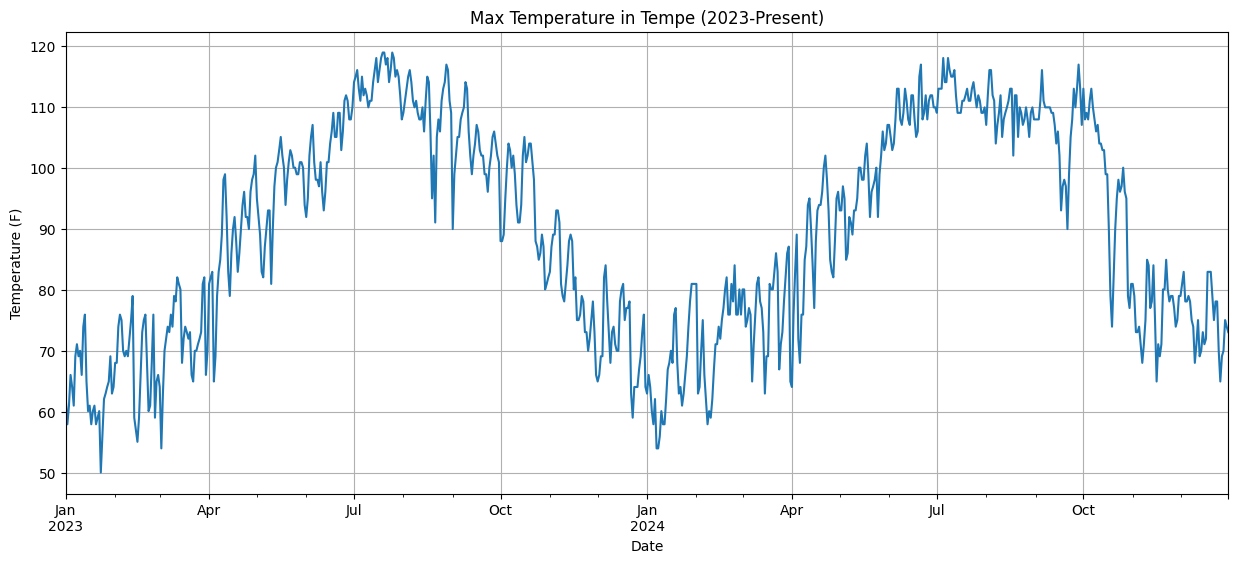

In [ ]:
import matplotlib.pyplot as plt
weather_df['TMAX'].plot(figsize= (15, 6),title = 'Max Temperature in Tempe (2023-Present)' )
plt.xlabel('Date')
plt.ylabel('Temperature (F)')
plt.grid(True)
plt.show()

In [ ]:
weather_df['month'] = weather_df.index.month
weather_df['day_of_year'] = weather_df.index.dayofyear
weather_df['day_of_week'] = weather_df.index.dayofweek
weather_df['year'] = weather_df.index.year
print(weather_df.head(), weather_df.tail())

             TMAX  month  day_of_year  day_of_week  year
date                                                    
2023-01-01  62.06      1            1            6  2023
2023-01-02  57.92      1            2            0  2023
2023-01-03  60.98      1            3            1  2023
2023-01-04  66.02      1            4            2  2023
2023-01-05  64.04      1            5            3  2023              TMAX  month  day_of_year  day_of_week  year
date                                                    
2024-12-27  69.08     12          362            4  2024
2024-12-28  69.98     12          363            5  2024
2024-12-29  75.02     12          364            6  2024
2024-12-30  73.94     12          365            0  2024
2024-12-31  73.04     12          366            1  2024


In [ ]:
weather_df['TMAX_yesterday'] = weather_df['TMAX'].shift(1)
weather_df = weather_df.dropna()
print(weather_df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 730 entries, 2023-01-02 to 2024-12-31
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TMAX            730 non-null    float64
 1   month           730 non-null    int32  
 2   day_of_year     730 non-null    int32  
 3   day_of_week     730 non-null    int32  
 4   year            730 non-null    int32  
 5   TMAX_yesterday  730 non-null    float64
dtypes: float64(2), int32(4)
memory usage: 28.5 KB
None


In [ ]:
features = ['month', 'day_of_year', 'day_of_week', 'year', 'TMAX_yesterday']
x = weather_df[features]
y = weather_df['TMAX']
split_point = len(weather_df) -180
x_train = x.iloc[:split_point]
y_train = y.iloc[:split_point]

x_test = x.iloc[split_point:]
y_test = y.iloc[split_point:]


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

model = RandomForestRegressor(n_estimators = 100, random_state = 42)
model.fit(x_train, y_train)

predictions = model.predict(x_test)
mae = mean_absolute_error(y_test, predictions)

print(f"Mean Absolute Error: Our Model is, on average {mae: .2f}°F off from the actual temperature.")

Mean Absolute Error: Our Model is, on average  3.43°F off from the actual temperature.


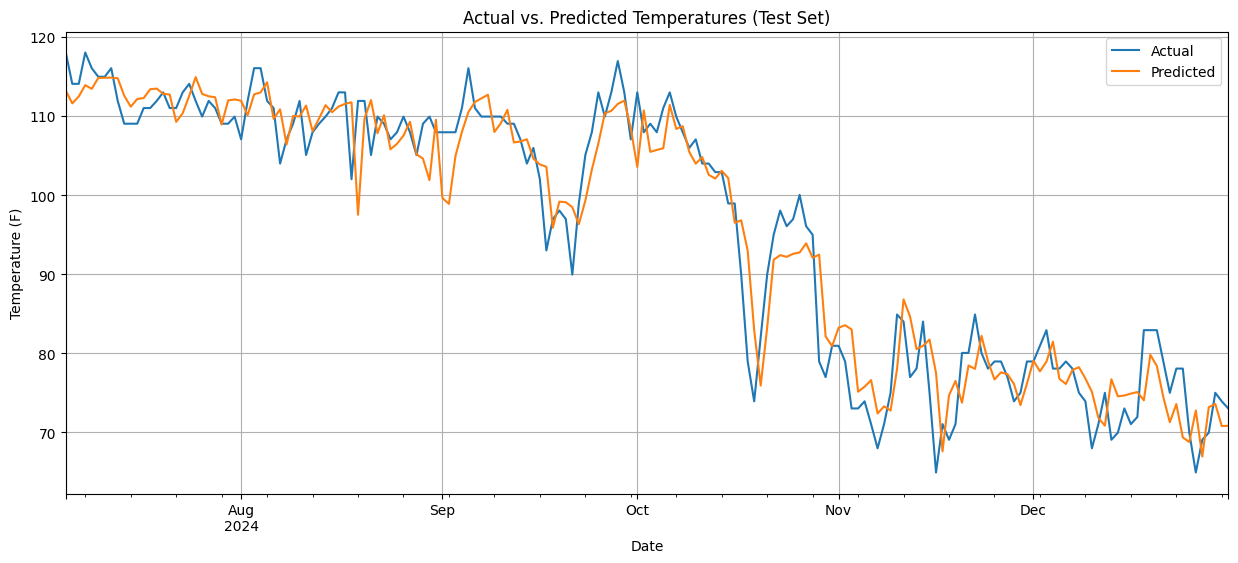

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

results_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})

results_df.plot(figsize = (15,6))
plt.title('Actual vs. Predicted Temperatures (Test Set)')
plt.xlabel('Date')
plt.ylabel('Temperature (F)')
plt.grid(True)
plt.show()

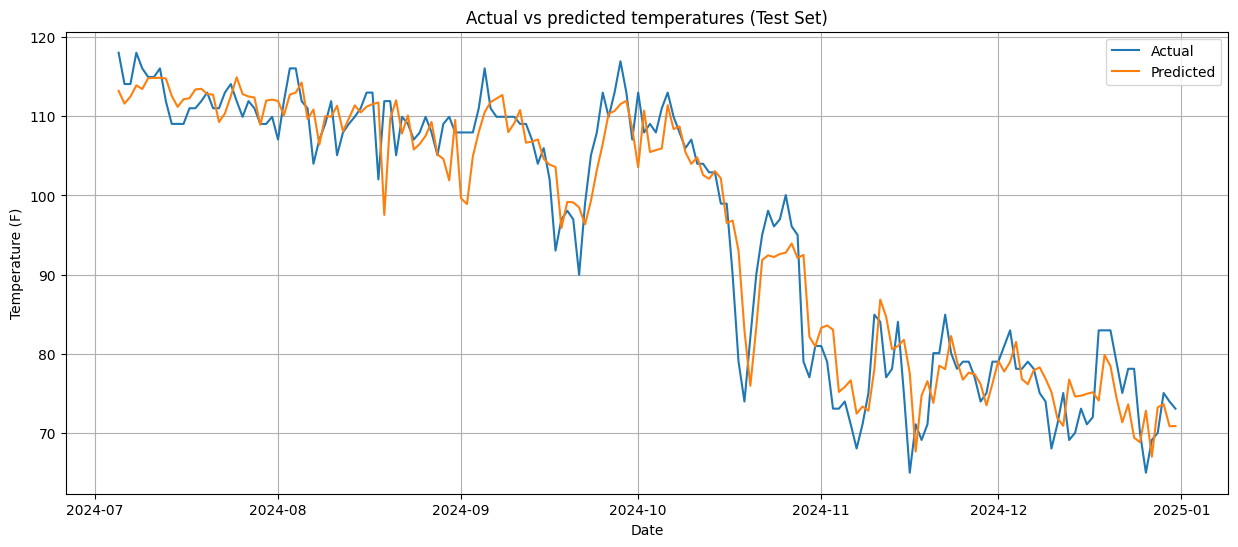

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize= (15,6) )
plt.plot(y_test.index ,y_test, label = 'Actual')
plt.plot(y_test.index, predictions, label = 'Predicted')
plt.title('Actual vs predicted temperatures (Test Set)')
plt.xlabel('Date')
plt.ylabel('Temperature (F)')
plt.grid(True)
plt.legend()
plt.show()

